# Autoencoder - mouse1

This notebook contains code accompanying the SpikeStability package for the autoencoder analysis related to Fig. 5 of the manuscript 'Tracking neural activity from the same cells during the entire adult life of mice'. A few useful things to note:
- The analysis is done per mouse and we have chosen to produce one such notebook for each mouse instead of a single python script being run independently on each mouse data.
- Results from each autoencoder are put together in a separate notebook.
- Useful comments and analysis will be included in this notebook but not for the other two mice as these overlap significantly. 
- Lines saving csvs and images are generally left commented here, should you wish to save the csvs to reproduce the statistic results across the three mice, make sure to uncomment the save_csv lines

In [1]:
## all necessary imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython import display
import PIL
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder

import glob
import time

#looking at the latent space 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import os 
os.chdir('..')

In [3]:
#fix random seed
from numpy.random import seed
seed(1)

In [5]:
import umap

# Load Dataset

We have a few useful datasets here. One with all collected spikes (that is, with minimal selection for high quality spikes so it potentially contains quite a few noisy events), one with strong processing thresholds ensuring only high quality spikes are kept and one with the anomaly dataset containing spikes from a different group of neurons to simulate drifting.

To make sure the autoencoder's performance is due to recording stability, we make sure to only give the very high quality spikes during training and keep the noisy dataset for testing. This means we are limiting the autoencoder's generalization capabilities and ensuring that high performance is an unbiased way of verifying recording stability.

In [7]:
your_path_to_data_dir = ''

In [9]:
df = pd.read_csv(your_path_to_data_dir +'/mouse1_all_spikes.csv')
df_postprocess = pd.read_csv(your_path_to_data_dir+'/mouse1_postprocess_data_strong.csv')

In [11]:
#outlier data
df_anomaly = pd.read_csv(your_path_to_data_dir+'/anomaly_spikes.csv')
X_anomaly = df_anomaly[['t'+str(i) for i in range(1, 31)]].values
labels_anomaly = df_anomaly['label_anomaly'].values

# Model architecture

Here we define the model and the relevant parameters.

In [13]:
spike_cols = ['t'+str(i) for i in range(1, 31)]
spikes = df[spike_cols].values

In [14]:
#params for AE
latent_dim = 2
dropout_rate = 0.2
input_shape = (spikes.shape[1],)
nb_neurons = df['neuron Wavemap'].unique().shape[0]
nb_channels = df['channel'].unique().shape[0]

#function based API for Keras
## encoder part
inputs = layers.Input(shape=input_shape)
inputs_channel = layers.Input(shape=(nb_channels,))
combined = layers.concatenate([inputs, inputs_channel])

x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(combined)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(latent_dim, activation=layers.LeakyReLU(alpha=0.3),
                activity_regularizer=regularizers.l2(1e-3))(x)

## classifier part
#need input of channel information


class_prob = layers.Dense(nb_neurons, activation="softmax",
                          name='classifier')(x)
encoded = layers.Dense(latent_dim, activation=layers.LeakyReLU(alpha=0.3),
                       name="latent")(x)

## decoder part
x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(encoded)
x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(x)
decoded = layers.Dense(input_shape[0], name='reconstruction')(x)

## full model
autoencoder = Model(inputs=[inputs, inputs_channel], outputs=[decoded, class_prob])
encoder = Model(inputs=[inputs, inputs_channel], outputs=encoded)
classifier = Model(inputs=[inputs, inputs_channel], outputs=class_prob)

# Train and test on 50/50 part of the dataset

Let's split the dataset into train and test! Here we split it into approximately 50/50. Note that metrics will be reported using test_all_spikes datasets which contain all the spikes (including some noise) driving metrics down and making the process more difficult for the autoencoder who has been trained on relatively few spikes.


## Training

In [15]:
X_test_all_spikes = df[df['dates'] >= 8.][spike_cols].values
labels_test_all_spikes = df[df['dates'] >= 8]['neuron Wavemap'].values
channels_test_all_spikes = df[df['dates'] >= 8]['channel'].values

In [16]:
df_ = df_postprocess.sort_values('dates')

In [17]:
df_train, df_test = train_test_split(df_, shuffle=False, test_size=0.5)
df_train, df_eval = train_test_split(df_train, shuffle=False, test_size=0.1)

In [19]:
X_train, X_eval, X_test = df_train[spike_cols].values, df_eval[spike_cols].values, df_test[spike_cols].values
labels_train, labels_eval, labels_test =  df_train['neuron Wavemap'].values, df_eval['neuron Wavemap'].values, df_test['neuron Wavemap'].values

In [20]:
#make sure labels are encoded
y_train = tf.keras.utils.to_categorical(labels_train, nb_neurons)
y_eval = tf.keras.utils.to_categorical(labels_eval, nb_neurons)
y_test = tf.keras.utils.to_categorical(labels_test, nb_neurons)

In [21]:
#make sure channels are encoded
nb_channels = len(df_train['channel'].unique())
mapping_dic = dict([(val, i) for i, val in enumerate(df_train['channel'].unique())])

channels_train = list(map(mapping_dic.get, df_train['channel'].values))
channels_test = list(map(mapping_dic.get, df_test['channel'].values))
channels_eval = list(map(mapping_dic.get, df_eval['channel'].values))
channels_test_all_spikes = list(map(mapping_dic.get, channels_test_all_spikes))

channels_train_enc = tf.keras.utils.to_categorical(channels_train, nb_channels)
channels_test_enc = tf.keras.utils.to_categorical(channels_test, nb_channels)
channels_eval_enc = tf.keras.utils.to_categorical(channels_eval, nb_channels)
channels_test_all_spikes_enc = tf.keras.utils.to_categorical(channels_test_all_spikes, nb_channels)

In [22]:
#training
autoencoder.compile(optimizer='adam',
                    loss=["mse", "categorical_crossentropy"],
                    loss_weights=[.01, 1],
                    metrics=['accuracy'])
#autoencoder.save_weights('model.h5') ##if you want to retrain multiple times
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 34)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          3500        concatenate[0][0]            

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
#custom callback for visualization of the training process
class ImageReconstruction(tf.keras.callbacks.Callback):
  def __init__(self, eval_data, eval_labels, eval_channels, save_interval, savedir):
    super(ImageReconstruction, self).__init__()
    self.savedir = savedir
    self.eval_data = eval_data
    self.eval_channels = eval_channels
    self.save_interval = save_interval
    self.eval_labels = eval_labels
    self.color_list = sns.color_palette('husl', len(np.unique(eval_labels)))

  def on_epoch_end(self, epoch, logs=None):
    scale = (np.min(self.eval_data) - 10, np.max(self.eval_data) + 10)
    if epoch % self.save_interval == 0:
      fig, axs = plt.subplots(2, len(np.unique(self.eval_labels)), figsize=(20, 4))
      fig.suptitle('Epoch '+str(epoch), y=1.05)
      for i, neuron_label in enumerate(np.unique(self.eval_labels)):
        mask = self.eval_labels == neuron_label 
        mean_waveform = np.mean(self.eval_data[mask], axis=0)
        corresponding_channel = self.eval_channels[mask][0]
        axs[0, i].set_ylim(scale)
        axs[0, i].plot(mean_waveform,
                      c=self.color_list[int(neuron_label)], lw=5.)
        axs[0, i].set_title('original')
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        #reconstruction
        decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                  np.reshape(corresponding_channel, (1, -1))])
        pred_label = np.argmax(pred_label)
        axs[1, i].plot(decoded_waveform[0],
                      c=self.color_list[pred_label], lw=5.)
        axs[1, i].set_title('reconstructed')
        axs[1, i].set_xticks([])
        axs[1, i].set_ylim(scale)
        axs[1, i].set_yticks([])
      fig.tight_layout()
      plt.savefig(self.savedir + '/' + f'epoch_{epoch}')
      plt.show()

class OutlierEvaluation(tf.keras.callbacks.Callback):
  def __init__(self, train_data, labels_train,
               channels_train,
               eval_data, labels_eval, channels_eval,
               outlier_data, labels_outlier):
    super(OutlierEvaluation, self).__init__()
    self.outlier_data = outlier_data
    self.train_data = train_data
    self.channels_train = channels_train
    self.eval_data = eval_data
    self.labels_train = labels_train
    self.labels_eval = labels_eval
    self.channels_eval = channels_eval
    self.labels_outlier = labels_outlier
  
  def on_train_begin(self, logs=None):
    self.model.history.history['reconstruction_outlier_loss'] = []
    self.model.history.history['max_prob_outlier'] = []
    self.model.history.history['max_prob_train'] = []
    self.model.history.history['max_prob_eval'] = []

    #calculate channel assignment for outlier data based on waveform similarity
    #KNN is used for channel assignment
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(self.train_data, self.channels_train)
    channels_outlier = neigh.predict(self.outlier_data)
    self.channels_outlier = channels_outlier
    
  def on_epoch_end(self, epoch, logs=None):
    #data
    decoded_train, pred_train = self.model([self.train_data,
                                            self.channels_train])
    decoded_eval, pred_eval = self.model([self.eval_data,
                                          self.channels_eval])
    decoded_outlier, pred_outlier = self.model([self.outlier_data,
                                                self.channels_outlier])
    #recon
    mse = mean_squared_error(self.outlier_data, decoded_outlier.numpy())
    self.model.history.history['reconstruction_outlier_loss'].append(mse)
    #max prob
    train_prob, eval_prob, outlier_prob = self.calculate_decoded_avg_waveforms()
    self.model.history.history['max_prob_train'].append(train_prob)
    self.model.history.history['max_prob_eval'].append(eval_prob)
    self.model.history.history['max_prob_outlier'].append(outlier_prob)

  def calculate_decoded_avg_waveforms(self, logs=None):
    #train
    train_probs = []
    for label in np.unique(self.labels_train): 
      mask = self.labels_train == label
      mean_waveform = np.mean(self.train_data[mask], axis=0)
      current_channel = self.channels_train[mask][0]
      decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                 np.reshape(current_channel, (1, -1))])
      train_probs.append(np.max(pred_label.numpy()))
    #eval
    eval_probs = []
    for label in np.unique(self.labels_eval):
      mask = self.labels_eval == label
      mean_waveform = np.mean(self.eval_data[mask], axis=0)
      current_channel = self.channels_eval[mask][0]
      decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                 np.reshape(current_channel, (1, -1))])
      eval_probs.append(np.max(pred_label.numpy()))
    #outlier
    outlier_probs = []
    for label in np.unique(self.labels_outlier):
      mask = self.labels_outlier == label
      mean_waveform = np.mean(self.outlier_data[mask], axis=0)
      current_channel = self.channels_outlier[mask][0]
      decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                 np.reshape(current_channel, (1, -1))])
      outlier_probs.append(np.max(pred_label.numpy()))
    #mean
    return np.mean(train_probs), np.mean(eval_probs), np.mean(outlier_probs)


In [26]:
#callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5
                   )

model_check = ModelCheckpoint('./autoencoder_notebooks/',
                              save_best_only=True,
                              save_weights_only=True,
                               monitor='val_loss')

image_printing = ImageReconstruction(X_eval, labels_eval, channels_eval_enc,
                                     5,
                                     './autoencoder_notebooks/')

outlier_eval = OutlierEvaluation(X_train, labels_train, channels_train_enc,
                                 X_eval, labels_eval, channels_eval_enc,
                                 X_anomaly, labels_anomaly)

In [ ]:
#autoencoder.load_weights('model.h5') #reinitialize
history = autoencoder.fit([X_train, channels_train_enc], [X_train, y_train],
                epochs=200,
                batch_size=100,
                callbacks=[es, model_check, image_printing, outlier_eval],
                validation_data=([X_eval, channels_eval_enc], [X_eval, y_eval]))

In [33]:
autoencoder.save_weights('./autoencoder_notebooks/best_model_current.h5')

In [28]:
autoencoder.load_weights('./data/best_model_current.h5')

**Important: to reproduce plots in the paper it is important to use the same model weights, these are provided in data/**

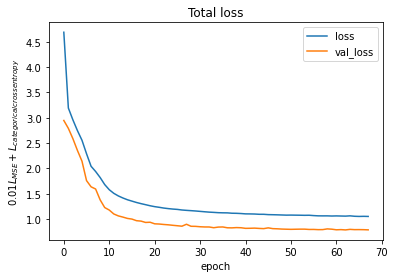

In [34]:
plt.title('Total loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('$0.01L_{MSE} + L_{categorical crossentropy}$')
plt.savefig('./autoencoders/results/AE_dense_classifier/total_loss_new_arch_current.pdf')
plt.legend()

In [ ]:
#reconstruction loss
plt.title('Reconstruction training curves')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.plot(history.history['reconstruction_loss'], label='reconstruction MSE')
plt.plot(history.history['val_reconstruction_loss'], label='val reconstruction MSE')
plt.plot(history.history['reconstruction_outlier_loss'], label='outlier loss')
#plt.savefig('./autoencoders/results/AE_dense_classifier/rec_loss_new_arch_final_current.pdf')
plt.legend()

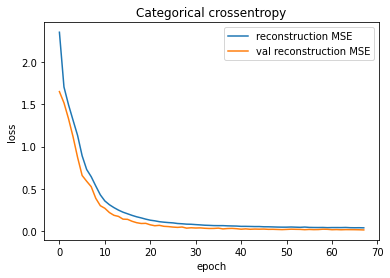

In [36]:
#reconstruction loss
plt.title('Categorical crossentropy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(history.history['classifier_loss'], label='reconstruction MSE')
plt.plot(history.history['val_classifier_loss'], label='val reconstruction MSE')

plt.savefig('./autoencoders/results/AE_dense_classifier/cat_crossentropy_new_arch_final_current.pdf')
plt.legend()

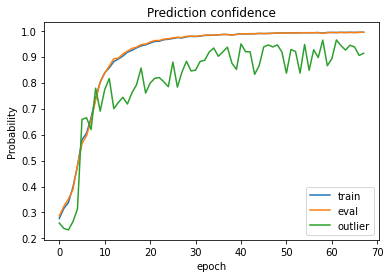

In [37]:
#reconstruction loss
plt.title('Prediction confidence')
plt.xlabel('epoch')
plt.ylabel('Probability')
plt.plot(history.history['max_prob_train'], label='train')
plt.plot(history.history['max_prob_eval'], label='eval')
plt.plot(history.history['max_prob_outlier'], label='outlier')
plt.savefig('./autoencoders/results/AE_dense_classifier/max_prob_confidence_final_current.pdf')
plt.legend()

## Testing

The rationale behind the next few cells is that as the autoencoder encodes both the spike and one hot encoded channel number, we need to give the anomalous spikes a fair shot at being reconstructed. To do so, we train a KNN to assign a supposed channel to each spike of the anomalous dataset. This means that anomalous spikes will be given a channel based on proximity of waveforms with the training dataset.

In [29]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, channels_train_enc)

KNeighborsClassifier(n_neighbors=3)

In [30]:
channels_anomaly = neigh.predict(X_anomaly)

In [31]:
#getting relevant data
encoded_train = encoder([X_train, channels_train_enc])
encoded_test = encoder([X_test, channels_test_enc])
encoded_test_all_spikes = encoder([X_test_all_spikes, channels_test_all_spikes_enc])

In [32]:
encoded_anomaly = encoder([X_anomaly, channels_anomaly])

In [33]:
decoded_train, pred_labels_train = autoencoder([X_train, channels_train_enc])
decoded_test, pred_labels_test = autoencoder([X_test, channels_test_enc])
decoded_test_all, pred_labels_test_all = autoencoder([X_test_all_spikes, channels_test_all_spikes_enc])

In [34]:
decoded_anomaly, pred_labels_anomaly = autoencoder([X_anomaly, channels_anomaly])

In [35]:
y_pred_test = np.argmax(pred_labels_test, axis=1)
y_pred_test_all = np.argmax(pred_labels_test_all, axis=1)
y_pred_train = np.argmax(pred_labels_train, axis=1)

In [36]:
#save to dataframe
df_labels = pd.DataFrame(labels_test_all_spikes, columns=['true_test'])
df_labels['pred_test'] = y_pred_test_all
df_labels['mouse'] = 1

In [37]:
#df_labels.to_csv('./autoencoder_notebooks//mouse1_test_labels.csv')

### Classification accuracy

In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#### On test dataset noisy spikes


In [39]:
print(classification_report(labels_test_all_spikes, y_pred_test_all))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     24614
           1       0.97      0.94      0.95     10012
           2       1.00      0.81      0.90     46796
           3       0.38      0.99      0.55      5681
           4       0.97      0.94      0.95     16028
           5       0.69      0.87      0.77      2613
           6       0.98      0.86      0.92     28633
           7       0.75      0.96      0.84     10912

    accuracy                           0.89    145289
   macro avg       0.84      0.92      0.86    145289
weighted avg       0.93      0.89      0.90    145289



In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix(labels_test_all_spikes, y_pred_test_all, normalize='true'),
                              display_labels=[i for i in range(8)])

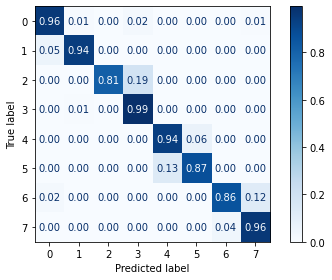

In [43]:
### Concatenated with results from two other mice to give Fig. 5 panel c.
disp.plot(cmap='Blues', values_format='.2f')
disp.figure_.tight_layout()
disp.ax_.grid(False)
#plt.savefig('./autoencoders/results/AE_dense_classifier/confusion_matrix_AE_test_all_spikes_final.pdf')

### Reconstruction

In [45]:
import seaborn as sns
color_list = sns.color_palette('husl', nb_neurons)

#### On noisy test data

In [46]:
y_test_all_spikes = tf.keras.utils.to_categorical(labels_test_all_spikes)

In [56]:
### Helper functions
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def plot_average_waveform_reconstructions(model,
                                  X_test,
                                  labels_test,
                                  test_channels,
                                  color_list,
                                  savefig,
                                  savefig_path,
                                  anomaly=False):
  fig, axs = plt.subplots(2, len(np.unique(labels_test)), figsize=(20, 4))
  scale = (np.min(X_test), np.max(X_test))
  for i, neuron_label in enumerate(np.unique(labels_test)):
      mask = labels_test == neuron_label
      mean_waveform = np.mean(X_test[mask], axis=0)
      current_channel = test_channels[mask][0]
      if anomaly:
        color = 'blue'
      else:
        color = color_list[neuron_label]
      axs[0, i].plot(mean_waveform,
                     c=color, lw=5.)
      
      axs[0, i].set_title('original')
      axs[0, i].set_xticks([])
      axs[0, i].set_yticks([])
      axs[0, i].set_ylim(scale)
      #reconstruction
      decoded_waveform, pred_label = model([np.reshape(mean_waveform, (1, -1)),
                                            np.reshape(current_channel, (1, -1))])
      pred_label = np.argmax(pred_label)
      if anomaly:
        color_pred = 'red'
      else:
        color_pred = color_list[pred_label] 
      axs[1, i].plot(decoded_waveform[0], c=color_pred, lw=5.)
      axs[1, i].set_title('reconstructed')
      axs[1, i].set_xticks([])
      axs[1, i].set_yticks([])
      axs[1, i].set_ylim(scale)
    
  if savefig:
    plt.savefig(savefig_path)
  fig.tight_layout()
  plt.show()

def plot_latent_space(encoded,
                      labels,
                      color_dic,
                      projection_method,
                      savefig,
                      savefig_path,
                      s=5.,   
                      lw=1.,
                      borders=True,
                      set_lims=False,
                      sil_score_show=True,
                      edgecolor='black',
                      figsize=(10, 10),
                      xlim=(-25, 25),
                      ylim=(-20, 30),
                      title='UMAP embedding of AE latent space'):
    
    if projection_method == 'tsne':
        print('TSNE calculation under way')
        X_embedded = TSNE(n_components=2).fit_transform(encoded)
        plt.scatter(X_embedded[:, 0],
                    X_embedded[:, 1],
                    c=list(map(color_dic.get, labels)),
                    s=2.)
        plt.xlabel('tSNE 1')
        plt.ylabel('tSNE 2')
        plt.title('tSNE embedding of AE latent space')
    elif projection_method == 'umap':
        print('UMAP calculation under way')
        X_embedded = umap.UMAP(n_neighbors=50,
                               min_dist=0.1,
                               metric='euclidean').fit_transform(encoded)

        plt.scatter(X_embedded[:, 0],
                    X_embedded[:, 1],
                    c=list(map(color_dic.get, labels)),
                    s=2.)
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.title(title)                     
    elif projection_method == 'pca':
        print('PCA calculation under way')
        X_embedded = PCA(n_components=2).fit_transform(encoded)
        plt.scatter(X_embedded[:, 0],
                    X_embedded[:, 1],
                    s=2.,
                    c=list(map(color_dic.get, labels)))
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
        plt.title('PCA embedding of AE latent space')
    elif projection_method == 'none':
        X_embedded = encoded
        fig, ax = plt.subplots(figsize=figsize)
        ax.scatter(X_embedded[:, 0],
                    X_embedded[:, 1],
                    s=s,
                    lw=lw,
                    edgecolor=edgecolor,
                    c=list(map(color_dic.get, labels)))
        ax.set_xticks([])
        ax.set_yticks([])
    if set_lims:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    if sil_score_show:
        sil_score = silhouette_score(X_embedded, labels)
        print('sil score '+str(sil_score))
    if borders:
        ax.set_xlabel('z 1')
        ax.set_ylabel('z 2')
        ax.set_title('AE latent space')
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    if savefig:
        if 'jpg' in savefig_path.split('.')[-1]:
            print('saving jpg')
            plt.savefig(savefig_path, dpi=300)
        else:
            plt.savefig(savefig_path)
    plt.show()
    if sil_score_show:
        return X_embedded, sil_score
    else:
        return X_embedded

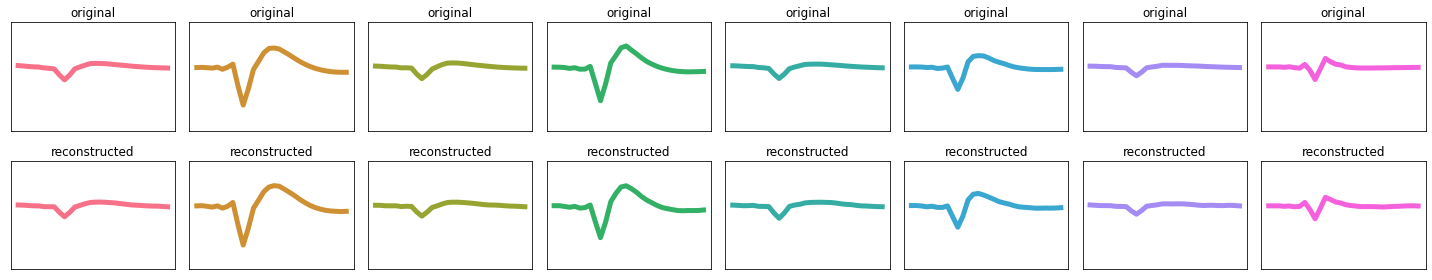

In [51]:
### Fig. 5 panel b
plot_average_waveform_reconstructions(autoencoder,
                              X_test_all_spikes, labels_test_all_spikes.astype('int'), channels_test_all_spikes_enc,
                              color_list,
                              False, './autoencoder_notebooks/rec_waveform_colored_AE_classifier_all_spikes_final.pdf')

### Latent space

#### Latent visualization of training data

In [53]:
color_dic = dict([(i, val) for i, val in enumerate(color_list)])

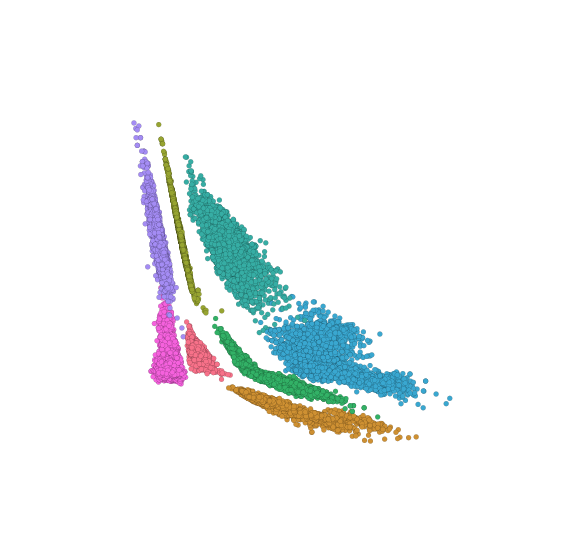

In [57]:
X_z_train = plot_latent_space(encoded_train.numpy(),
                              labels_train,
                              color_dic,
                              'none',
                              False, "./autoencoder_notebooks/train_latent_space_final_no_borders.jpg",
                              s=25.,
                              lw=0.1,
                              borders=False,
                              set_lims=True,
                              figsize=(10, 10),
                              xlim=(-10, 20),
                              ylim=(-10, 20),
                              sil_score_show=False)

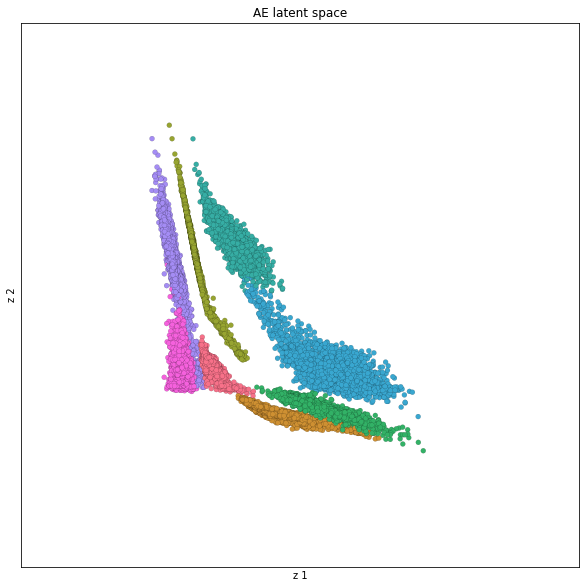

In [58]:
X_z_test_clean = plot_latent_space(encoded_test.numpy(),
                                  labels_test,
                                  color_dic,
                                  'none',
                                  False,
                                  "./autoencoder_notebooks/test_latent_space_final.pdf",
                                  s=25.,
                                  lw=0.1,
                                  set_lims=True,
                                  xlim=(-10, 20),
                                  ylim=(-10, 20),
                                  sil_score_show=False)

processing channel 13.0
sil score 0.78046566


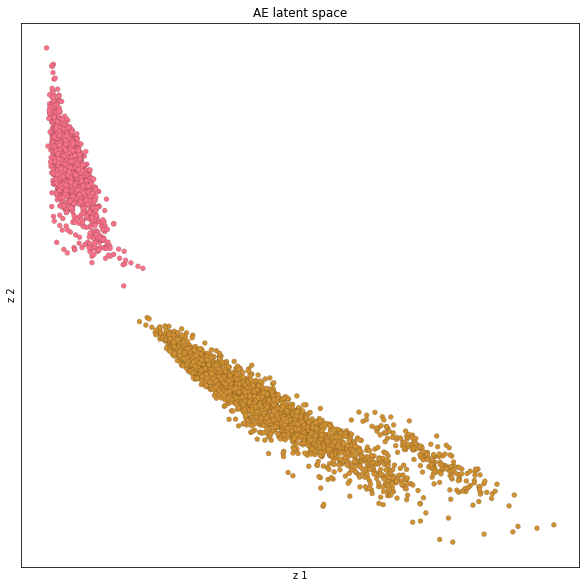

processing channel 17.0
sil score 0.79153705


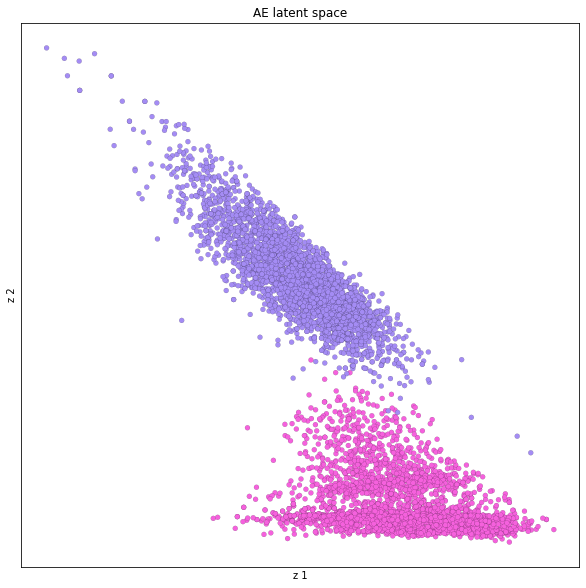

processing channel 21.0
sil score 0.7997727


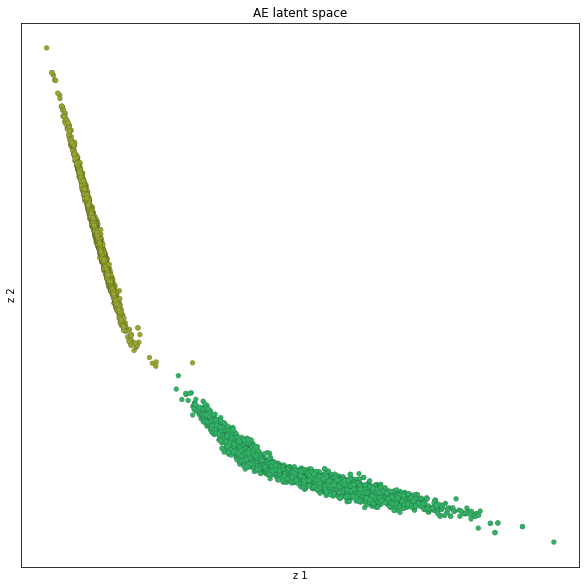

processing channel 9.0
sil score 0.7449028


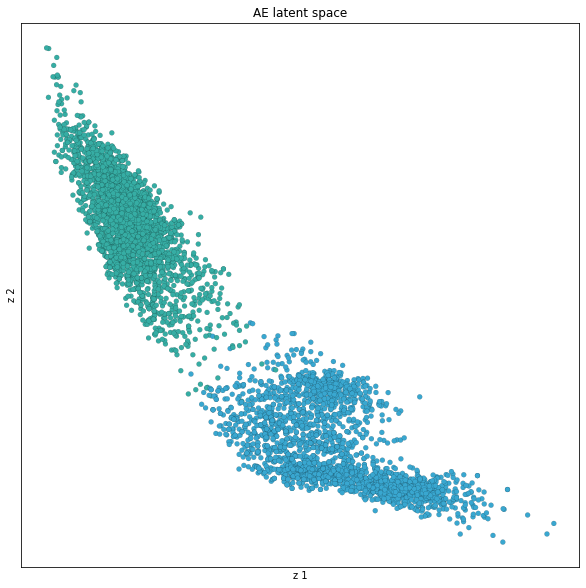

In [59]:
sil_scores_train = []

for channel in df_train['channel'].unique():
    print('processing channel '+str(channel))
    mask = df_train['channel'] == channel
    labels_ = labels_train[mask]
    encoded_ = encoded_train.numpy()[mask]
    X_, sil_score = plot_latent_space(encoded_,
                                      labels_,
                                      color_dic,
                                      'none',
                                      False,
                                      f'./autoencoder_notebooks/AE_train_latent_space_CH{channel}_final.pdf',
                                      title=f'',
                                     s=25.,
                                     sil_score_show=True,
                                     lw=0.1,)

    sil_scores_train.append(sil_score)

#### Latent visualization on noisy test data

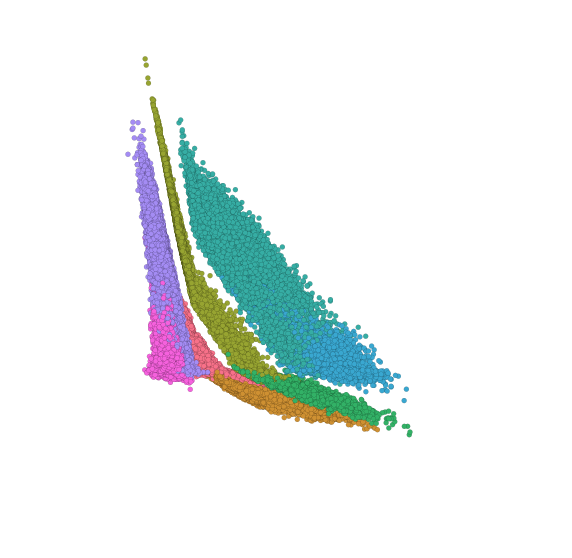

In [62]:
X_z = plot_latent_space(encoded_test_all_spikes.numpy(),
                      labels_test_all_spikes,
                      color_dic,
                      'none',
                      False,
                      "./autoencoder_notebooks/test_all_spikes_latent_space_final_no_border_scale.jpg",
                      sil_score_show=False,
                      borders=False,
                      s=25.,
                      set_lims=True,
                      xlim=(-10, 20),
                      ylim=(-10, 20),
                      lw=0.1)

processing channel 0
sil score 0.6317328


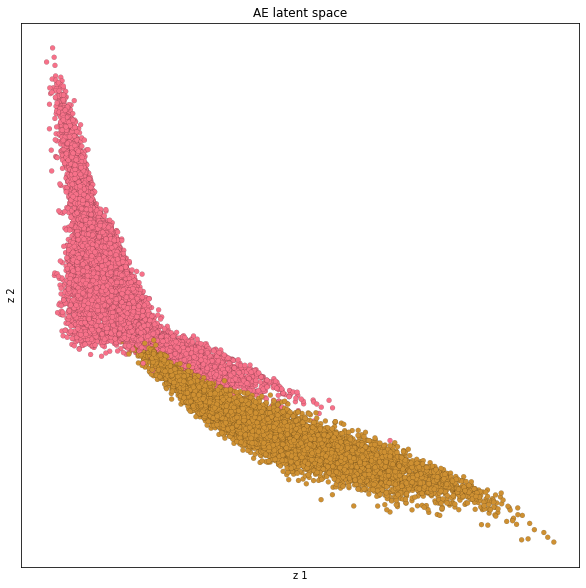

processing channel 1
sil score 0.52367043


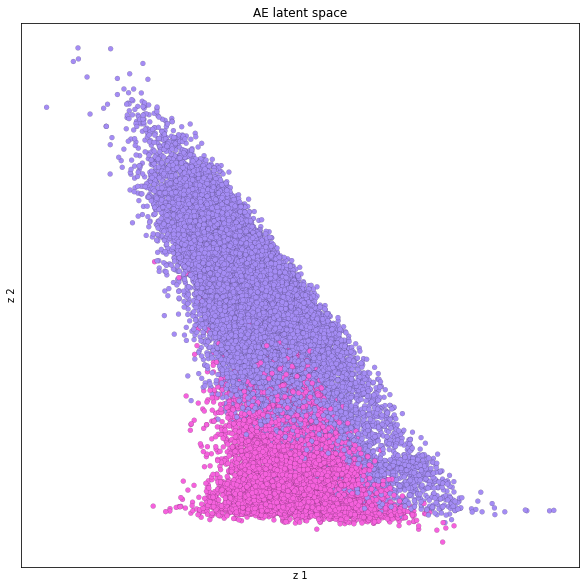

processing channel 2
sil score 0.5887827


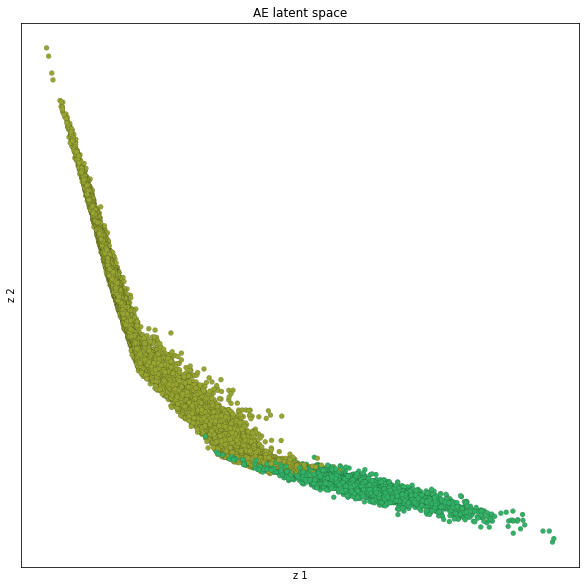

processing channel 3
sil score 0.5948997


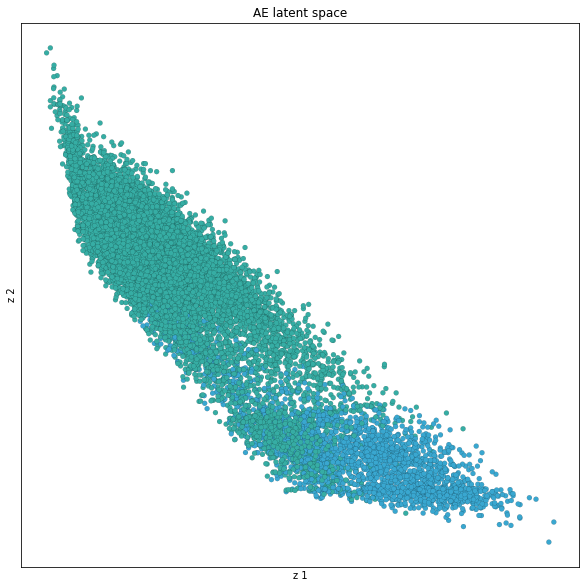

In [64]:
sil_scores_test_noisy = []

for channel in np.unique(channels_test_all_spikes):
    print('processing channel '+str(channel))
    mask = channels_test_all_spikes == channel
    labels_ = labels_test_all_spikes[mask]
    encoded_ = encoded_test_all_spikes.numpy()[mask]
    X_, sil_score = plot_latent_space(encoded_,
                              labels_,
                              color_dic,
                              'none',
                              False,
                              f'./autoencoder_notebooks/AE_all_spikes_latent_space_CH{channel}_latent.pdf',
                              title=f'',
                              sil_score_show=True,
                              lw=.1,
                              s=25.)
    sil_scores_test_noisy.append(sil_score)

In [66]:
color_list2 = sns.color_palette('tab10')
color_dic2 = dict([(i, val) for i, val in enumerate(color_list2)])

sil score -0.24496181


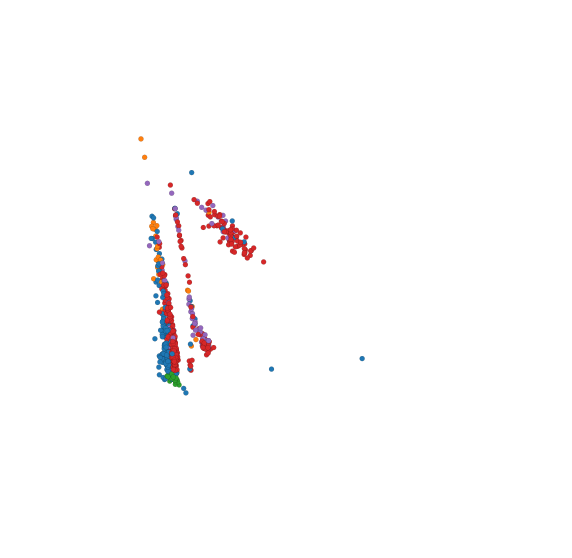

In [67]:
X_z_anomaly, sil_score_anomaly = plot_latent_space(encoded_anomaly.numpy(),
                                                  labels_anomaly,
                                                  color_dic2,
                                                  'none',
                                                  False, "./autoencoder_notebooks/anomaly_mouse1.jpg",
                                                  lw=0.1,
                                                  s=25.,
                                                  set_lims=True,
                                                  xlim=(-10, 20),
                                                  figsize=(10, 10),
                                                  ylim=(-10, 20),
                                                  borders=False,
                                                  sil_score_show=True)

Obtain convex hulls associated with each neuron to obtain training manifold and quantify noise in testing dataset.

In [69]:
from scipy.spatial import ConvexHull
from descartes import PolygonPatch
import alphashape

In [70]:
hull_train = ConvexHull(encoded_train.numpy(), incremental=True)
hull_anomaly = ConvexHull(encoded_anomaly.numpy(), incremental=True)

In [71]:
alpha_shape_train = alphashape.alphashape(encoded_train.numpy(), 0.1)
alpha_shape_anomaly = alphashape.alphashape(encoded_anomaly.numpy(), 0.1)

#### Latent space panel comparison train noisy outlier

In [72]:
from mpl_toolkits import mplot3d

In [73]:
color_list2 = sns.color_palette('tab10')
color_dic2 = dict([(i, val) for i, val in enumerate(color_list2)])

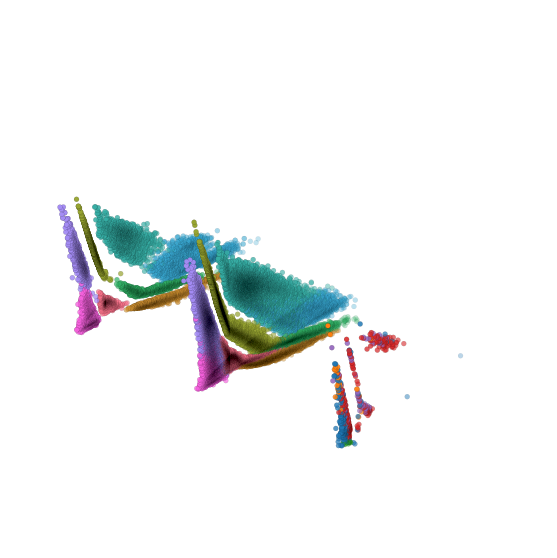

In [74]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")


ax.scatter(np.ones(encoded_test_all_spikes.numpy().shape[0])+0.5, encoded_test_all_spikes.numpy()[:, 0], 
           encoded_test_all_spikes.numpy()[:, 1], c=list(map(color_dic.get, labels_test_all_spikes)), s=25., lw=0.1, edgecolor='black')

ax.scatter(np.ones(encoded_train.numpy().shape[0]), encoded_train.numpy()[:, 0], 
           encoded_train.numpy()[:, 1], c=list(map(color_dic.get, labels_train)), s=25., lw=0.1, edgecolor='black')

ax.scatter(np.ones(encoded_anomaly.numpy().shape[0])+1., encoded_anomaly.numpy()[:, 0], 
           encoded_anomaly.numpy()[:, 1], c=list(map(color_dic2.get, labels_anomaly)), s=25., lw=0.1, edgecolor='black')

ax.azim = -50
ax.set_xlim(1, 2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_axis_off()
plt.show()

In [75]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull.points)

    return hull.find_simplex(p)>=0

#### Latent visualization of channels on noisy dataset with noise detection from AE



In [76]:
custom_color_list = ['#AF3461', '#996425',  '#337C18', '#376352','#037C79', '#076493',
    '#7517E2', 'black' ]

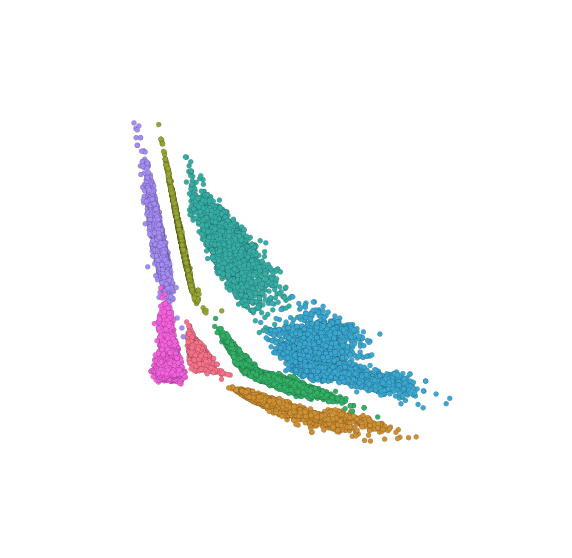

In [91]:
### Used for inset of Fig5. panel f

#get convex hull of each training neuron clust
convex_hulls_training = []
polygons = []

fig, ax = plt.subplots(figsize=(10, 10))

for i, neuron in enumerate(sorted(np.unique(labels_train))):
  mask = labels_train == neuron 
  X_train_ = encoded_train.numpy()[mask]
  hull_ =  ConvexHull(X_train_, incremental=True)
  convex_hulls_training.append(hull_)
  ax.scatter(X_train_[:, 0], X_train_[:, 1], c=list(map(color_dic.get,
                                                        labels_train[mask])),
             s=25., lw=.1, edgecolor='black')
  poly_ = plt.Polygon(X_train_[hull_.vertices, :], fc=None, ec=custom_color_list[i],
                           linewidth=3., fill=False, linestyle='--')
  #ax.add_patch(poly_)  ##uncomment this line to obtain convex hulls
  polygons.append(poly_)

ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#plt.savefig('./autoencoders/results/AE_dense_classifier/train_latent_space_boundaries_no_borders_scale_with_dots.jpg', dpi=300)
plt.show()

In [79]:
#add processing for each predicted neuron in noisy dataset
X_test_no_noise = []
channel_test_no_noise = []
spikes_test_no_noise = []
labels_test_no_noise = []
real_labels_test_no_noise = []

X_test_rejected = []
channels_test_rejected = []
spikes_test_rejected = []
labels_test_rejected = []
real_labels_test_rejected = []

for i, neuron in enumerate(sorted(np.unique(y_pred_test_all))):
  mask1 = y_pred_test_all == neuron
  #make sure only one channel is used for a given neuron
  channel_ = np.array(channels_test_all_spikes)[mask1]
  values, channel_counts = np.unique(channel_, return_counts=True)
  print(np.unique(channel_)[np.argmax(channel_counts)])
  max_chan = np.unique(channel_)[np.argmax(channel_counts)]
  mask2 = np.array(channels_test_all_spikes) == max_chan
  mask = mask1 & mask2
  #current
  channel_ = np.array(channels_test_all_spikes)[mask]
  X_test_ = encoded_test_all_spikes.numpy()[mask]
  y_pred_ = y_pred_test_all[mask]
  spikes_ = X_test_all_spikes[mask]
  labels_test_ = labels_test_all_spikes[mask]
  #keep rejected
  channels_test_rejected.append(np.array(channels_test_all_spikes)[mask1&~mask2])
  labels_test_rejected.append(y_pred_test_all[mask1&~mask2])
  real_labels_test_rejected.append(labels_test_all_spikes[mask1&~mask2])
  spikes_test_rejected.append(X_test_all_spikes[mask1&~mask2])
  X_test_rejected.append(encoded_test_all_spikes.numpy()[mask1&~mask2])
  #rejection
  new_mask = in_hull(X_test_, convex_hulls_training[i])
  X_test_no_noise.append(X_test_[new_mask])
  #append
  channel_test_no_noise.append(channel_[new_mask])
  labels_test_no_noise.append(y_pred_[new_mask])
  real_labels_test_no_noise.append(labels_test_[new_mask])
  spikes_test_no_noise.append(spikes_[new_mask])

  X_test_rejected.append(X_test_[~new_mask])
  channels_test_rejected.append(channel_[~new_mask])
  labels_test_rejected.append(y_pred_[~new_mask])
  real_labels_test_rejected.append(labels_test_[~new_mask])
  spikes_test_rejected.append(spikes_[~new_mask])

0
0
2
2
3
3
1
1


In [80]:
X_test_no_noise = np.vstack(X_test_no_noise)
channel_test_no_noise = np.hstack(channel_test_no_noise)
labels_test_no_noise = np.hstack(labels_test_no_noise)
real_labels_test_no_noise = np.hstack(real_labels_test_no_noise)
spikes_test_no_noise = np.vstack(spikes_test_no_noise)

In [81]:
X_test_rejected = np.vstack(X_test_rejected)
channels_test_rejected = np.hstack(channels_test_rejected)
labels_test_rejected = np.hstack(labels_test_rejected)
real_labels_test_rejected = np.hstack(real_labels_test_rejected)
spikes_test_rejected = np.vstack(spikes_test_rejected)

In [85]:
rejection_probs = []
labels_rejection = []
counts_no_noise = []
counts_rejected = []
for label in np.unique(labels_test_no_noise):
    sum_labels_no_noise = np.sum(labels_test_no_noise == label)
    sum_labels_noise = np.sum(labels_test_rejected == label)
    rejection_probs.append(sum_labels_noise/(sum_labels_noise+sum_labels_no_noise))
    labels_rejection.append(label)
    counts_no_noise.append(sum_labels_no_noise)
    counts_rejected.append(sum_labels_noise)

In [86]:
df_rejection = pd.DataFrame(rejection_probs, columns=['Percentage_noise'])
df_rejection['count_normal'] = counts_no_noise
df_rejection['count_noise'] = counts_rejected
df_rejection['label'] =  labels_rejection
df_rejection['mouse'] = 1

In [87]:
df_rejection.head()

,Percentage_noise,count_normal,count_noise,label,mouse
0,0.148834,21057,3682,0,1
1,0.195202,7850,1904,1,1
2,0.105789,34014,4024,2,1
3,0.091196,13523,1357,3,1
4,0.031473,14925,485,4,1


In [88]:
#df_rejection.to_csv('./autoencoder_notebooks/noise_rejection_levels_mouse1.csv')

In [89]:
xlims = []
ylims = []

custom_color_list = ['#AF3461', '#996425', 'black', '#7517E2', '#337C18', '#376352',
    '#037C79', '#076493']

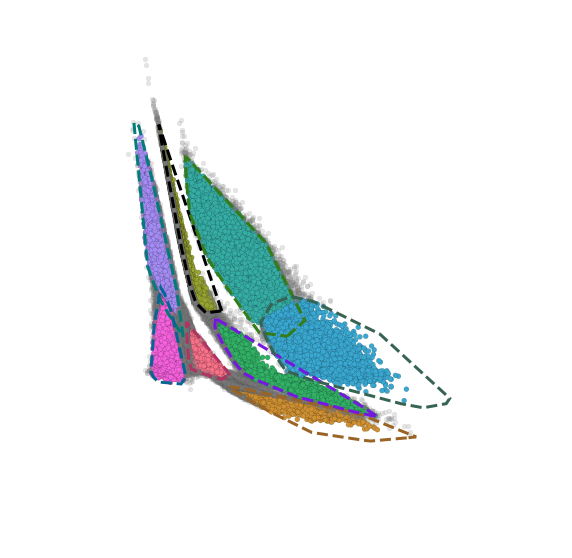

In [92]:
## Fig 5. panel f inset

fig, ax = plt.subplots(figsize=(10, 10))

for i, channel in enumerate(np.unique(channel_test_no_noise)):
  mask = np.array(channel_test_no_noise) == channel
  mask_noise = np.array(channels_test_rejected) == channel
  X_ = X_test_no_noise[mask]
  X_rejected_ = X_test_rejected[mask_noise]
  neurons_ = np.unique(labels_test_no_noise[mask])
  ax.scatter(X_[:, 0], X_[:, 1],
               s=25., lw=0.1, c=list(map(color_dic.get, labels_test_no_noise[mask])),
               edgecolor='black')
  ax.scatter(X_rejected_[:, 0], X_rejected_[:, 1],
               s=25., lw=0.1, color='grey', alpha=0.2,
               edgecolor='black')
  for n in neurons_:
    ax.add_patch(polygons[n])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#plt.savefig('./autoencoder_notebooks/noisy_processed_latent_space_all_channels_no_borders_only_boundaries'+'.jpg', dpi=300)
plt.show()


#### Latent space metrics

In [95]:
list_sil_scores = sil_scores_train+sil_scores_test_noisy+[sil_score_anomaly]

In [96]:
list_dataset_type = ['train' for _ in sil_scores_train] + ['test' for _ in sil_scores_test_noisy] + ['anomaly']

df_sil_score = pd.DataFrame(list_sil_scores, columns=['silhouette_score'])
df_sil_score['dataset_type'] = list_dataset_type

<AxesSubplot:xlabel='dataset_type', ylabel='silhouette_score'>

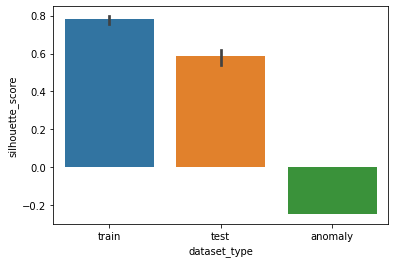

In [97]:
sns.barplot(x='dataset_type', y='silhouette_score', data=df_sil_score)
#plt.savefig('./autoencoder_notebooks/sil_score_final_mouse1.pdf')

In [ ]:
#df_sil_score.to_csv('./autoencoder_notebooks/sil_scores_data_mouse1.csv')

### Testing time

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
#timing UMAP on training dataset + supervised training of RF
# %%timeit -n1 -r1
#run this 5 time for individual results

###train
mapper = umap.UMAP(n_components=2,
                   n_neighbors=50,
                   min_dist=0.1,
                   metric='euclidean').fit(X_train)

X_embedded = mapper.transform(X_train)
clf = RandomForestClassifier(n_estimators=200,
                             criterion='gini',
                             verbose=1)
clf.fit(X_embedded, labels_train)

print('Training done')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training done


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.0s finished


In [ ]:
## This should be filled with the results obtained from running the testing time cell 5 times!
umap_training_times = [27.5, 27.4, 28.2, 26.3, 28.3]

In [213]:
%%timeit -n 1 -r 1
#umap testing times, use already trained RF
#run this 5 time for results
X_embedded = mapper.transform(X_test_all_spikes)

y_pred_rf = clf.predict(X_embedded)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


10min 7s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.2s finished


In [ ]:
%%timeit -n1 -r1
# run this 5 times and write down results
decoded_test, pred_test = autoencoder([X_test_all_spikes,
                                       channels_test_all_spikes_enc])

1 loop, best of 1: 31.6 ms per loop


In [ ]:
umap_testing_time_noisy = [607, 580, 577, 585, 593]

In [ ]:
#this will definitely influence run time, here are my specs for comparison
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [ ]:
ae_testing_times_noisy = [35.8e-3, 30.5e-3, 30.1e-3, 30.8e-3, 31.6e-3]
ae_training_time = [34.2, 50.5, 84.3, 45.5, 48.7]

# Comparing MSEs

Here, we will quantitatively assess autoencoder performance on the reconstruction task. Recording stability should ensure that although the autoencoder has only seen very few spikes during training, the testing MSE is within the same range whereas the 'anomaly' simulating drift is much higher.

In [103]:
mse_train = ((decoded_train.numpy() - X_train)**2).mean(axis=1)
mse_test = ((decoded_test.numpy() - X_test)**2).mean(axis=1)
mse_test_noisy = ((decoded_test_all.numpy() - X_test_all_spikes)**2).mean(axis=1)
mse_anomaly = ((decoded_anomaly.numpy() - X_anomaly)**2).mean(axis=1)

In [104]:
threshold = np.mean(mse_train) + 2*np.std(mse_train)

In [105]:
df_plot1 = pd.DataFrame(np.hstack([mse_train, mse_test_noisy, mse_anomaly]), columns=['mse'])
df_plot1['type'] = np.hstack([['train' for _ in range(len(mse_train))],
                        ['test' for _ in range(len(mse_test_noisy))],
                        ['anomaly' for _ in range(len(mse_anomaly))]])

In [107]:
#df_plot1.to_csv('./autoencoder_notebooks//mse_mouse1.csv')

In [113]:
decoded_train_avg = []
mean_wfs_train = []
preds_train_avg = []

for neuron_label in np.unique(labels_train):
  mask = labels_train == neuron_label
  mean_wf = np.mean(X_train[mask], axis=0)
  mean_wfs_train.append(mean_wf)
  current_chan = channels_train_enc[mask][0]
  decoded_, pred_ = autoencoder([np.reshape(mean_wf, (1, -1)),
                                            np.reshape(current_chan, (1, -1))])
  preds_train_avg.append(pred_)
  decoded_train_avg.append(decoded_.numpy())

In [114]:
decoded_test_avg = []
mean_wfs_test = []
preds_test_avg = []

for neuron_label in np.unique(labels_test):
  mask = labels_test == neuron_label
  mean_wf = np.mean(X_test[mask], axis=0)
  mean_wfs_test.append(mean_wf)
  current_chan = channels_test_enc[mask][0]
  decoded_, pred_ = autoencoder([np.reshape(mean_wf, (1, -1)),
                                            np.reshape(current_chan, (1, -1))])
  preds_test_avg.append(pred_)
  decoded_test_avg.append(decoded_.numpy())

In [115]:
decoded_anomaly_avg = []
mean_wfs_anomaly = []

for neuron_label in np.unique(labels_anomaly):
  mask = labels_anomaly == neuron_label
  mean_wf = np.mean(X_anomaly[mask], axis=0)
  mean_wfs_anomaly.append(mean_wf)
  current_chan = channels_anomaly[mask][0]
  decoded_, pred_ = autoencoder([np.reshape(mean_wf, (1, -1)),
                                            np.reshape(current_chan, (1, -1))])
  decoded_anomaly_avg.append(decoded_.numpy())

In [116]:
decoded_train_avg = np.vstack(decoded_train_avg)
mean_wfs_train = np.vstack(mean_wfs_train)
decoded_anomaly_avg = np.vstack(decoded_anomaly_avg)
mean_wfs_anomaly = np.vstack(mean_wfs_anomaly)
mean_wfs_test = np.vstack(mean_wfs_test)
decoded_test_avg = np.vstack(decoded_test_avg)

In [117]:
mse_train_avg = ((decoded_train_avg - mean_wfs_train)**2).mean(axis=1)
mse_anomaly_avg = ((decoded_anomaly_avg - mean_wfs_anomaly)**2).mean(axis=1)
mse_test_avg = ((decoded_test_avg - mean_wfs_test)**2).mean(axis=1)

In [118]:
mse_train_avg

array([0.5137288 , 1.7842127 , 0.56097989, 0.41825598, 0.63238252,
       1.64525497, 0.44136445, 1.00594316])

The next three plots were used to create the inset of Fig.5 panel d.

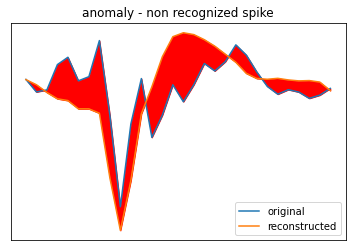

In [123]:
t = np.arange(len(mean_wfs_anomaly[1]))
plt.plot(t, mean_wfs_anomaly[1], label='original')
plt.plot(t, decoded_anomaly_avg[1], label='reconstructed')
plt.fill_between(t, mean_wfs_anomaly[1],
                 decoded_anomaly_avg[1], color='red')
plt.xticks([])
plt.yticks([])
plt.title('anomaly - non recognized spike')
#plt.savefig('./autoencoder_notebooks/anomaly_spike_mouse1.pdf')
plt.legend()
plt.show()

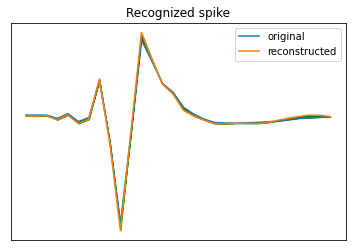

In [124]:
t = np.arange(len(mean_wfs_train[7]))
plt.plot(t, mean_wfs_train[7], label='original')
plt.plot(t, decoded_train_avg[7], label='reconstructed')
plt.fill_between(t, mean_wfs_train[7],
                 decoded_train_avg[7], color='green')
plt.xticks([])
plt.yticks([])
plt.title('Recognized spike')
#plt.savefig('./autoencoder_notebooks/train_spike_mouse1.pdf')
plt.legend()
plt.show()

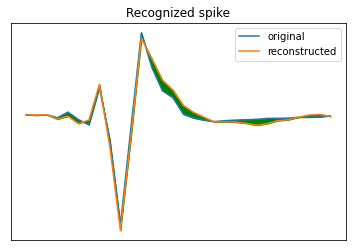

In [125]:
t = np.arange(len(mean_wfs_test[7]))
plt.plot(t, mean_wfs_test[7], label='original')
plt.plot(t, decoded_test_avg[7], label='reconstructed')
plt.fill_between(t, mean_wfs_test[7],
                 decoded_test_avg[7], color='green')
plt.xticks([])
plt.yticks([])
plt.title('Recognized spike')
#plt.savefig('./autoencoder_notebooks/test_spike_mouse1.pdf')
plt.legend()
plt.show()

## Conclusion

Presented here are the results from autoencoder analysis on mouse1, statistic results were obtained by pooling all the saved csvs after running each notebook. Thanks for making it this far :)